# Comparison of the models
@LuiseJedlitschka

We decided to train the following models: MLP, Random Forest, XGBoost.
We trained them on stratified 80/20 split and on leave-one-group-out splits (one dataset as testset each).
These trained models are being compared here in their accuracy using confusion matrices and metrics (precision, recall, f1).

In [19]:
import joblib
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

=== Split 0 ===
Model 'mlp' was not trained on Split 0.
Model 'randomforest' was not trained on Split 0.


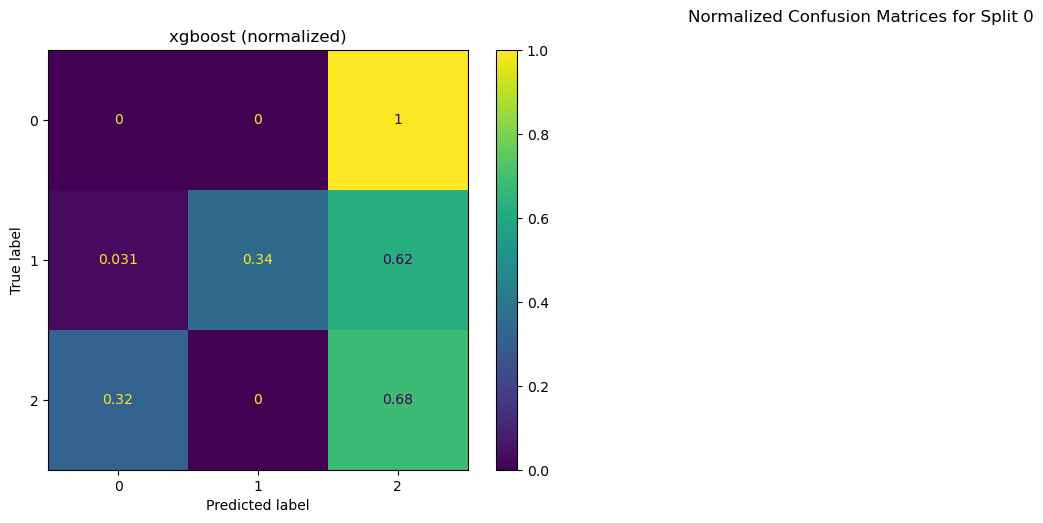

,Split,Model,Accuracy,Precision,Recall,F1
0,0,xgboost,0.444444,0.71965,0.444444,0.469517


=== Split 1 ===
Model 'mlp' was not trained on Split 1.
Model 'randomforest' was not trained on Split 1.


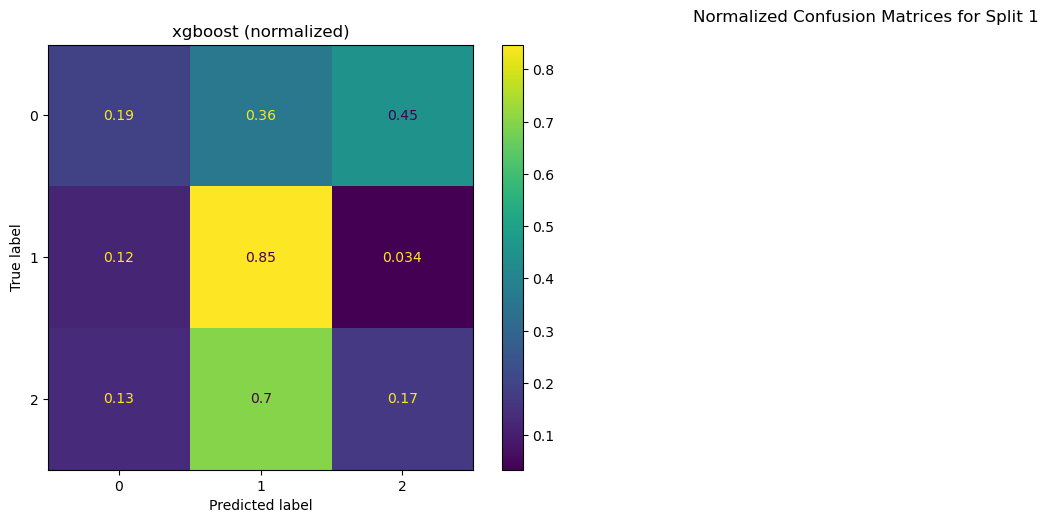

,Split,Model,Accuracy,Precision,Recall,F1
0,1,xgboost,0.345992,0.357985,0.345992,0.300795


=== Split 2 ===
Model 'mlp' was not trained on Split 2.
Model 'randomforest' was not trained on Split 2.


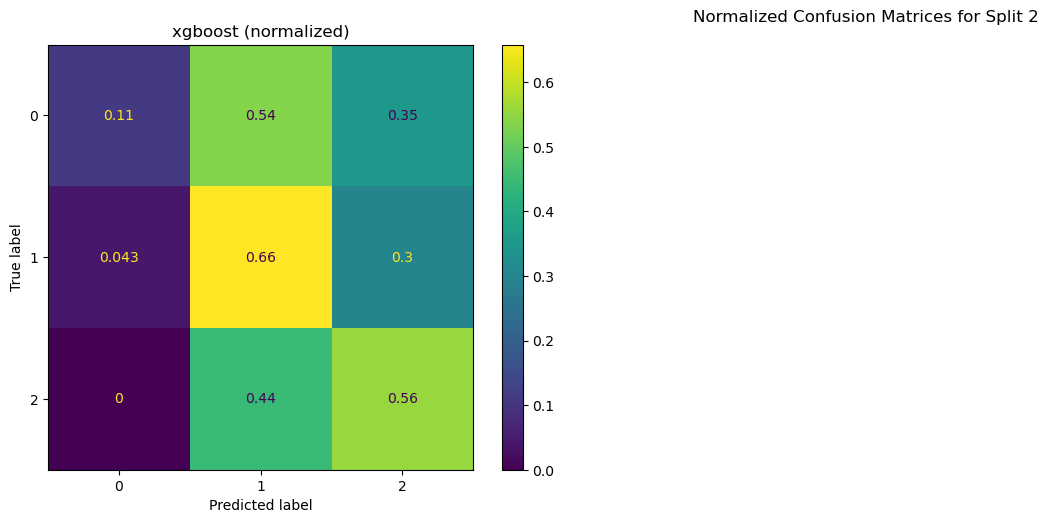

,Split,Model,Accuracy,Precision,Recall,F1
0,2,xgboost,0.347222,0.628026,0.347222,0.331925


=== Split 3 ===
Model 'mlp' was not trained on Split 3.
Model 'randomforest' was not trained on Split 3.


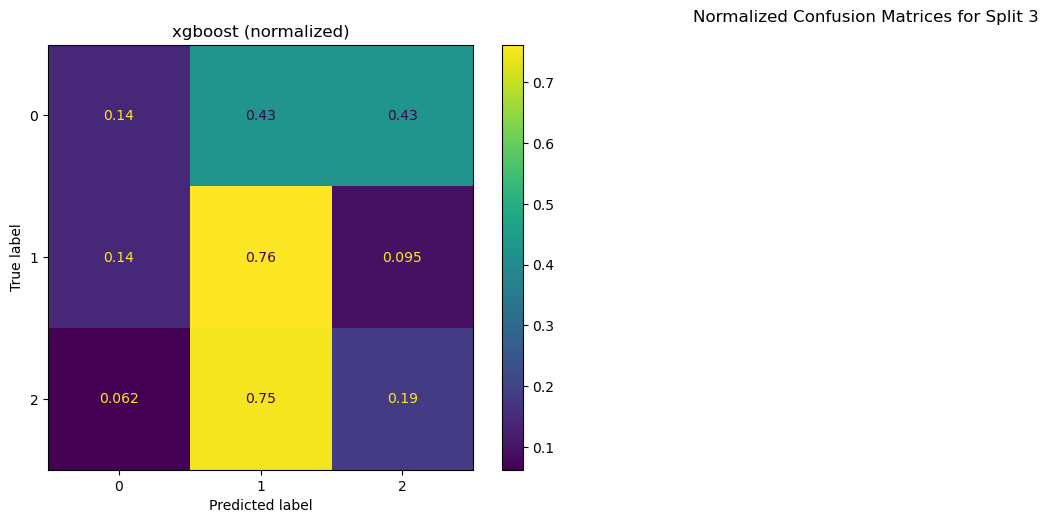

,Split,Model,Accuracy,Precision,Recall,F1
0,3,xgboost,0.383333,0.440586,0.383333,0.341786


=== Split 4 ===
Model 'mlp' was not trained on Split 4.
Model 'randomforest' was not trained on Split 4.


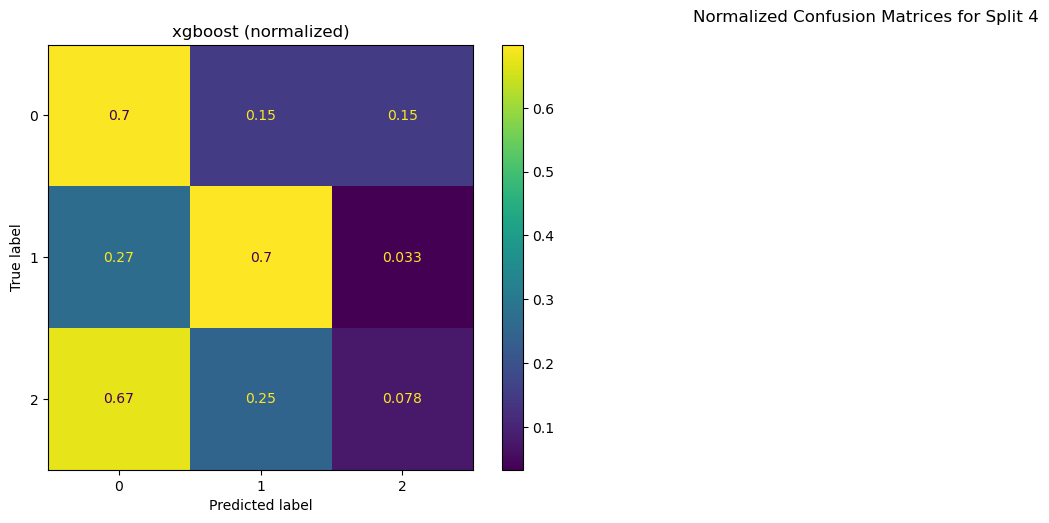

,Split,Model,Accuracy,Precision,Recall,F1
0,4,xgboost,0.420824,0.576854,0.420824,0.40452


=== Split 5 ===
Model 'mlp' was not trained on Split 5.
Model 'randomforest' was not trained on Split 5.


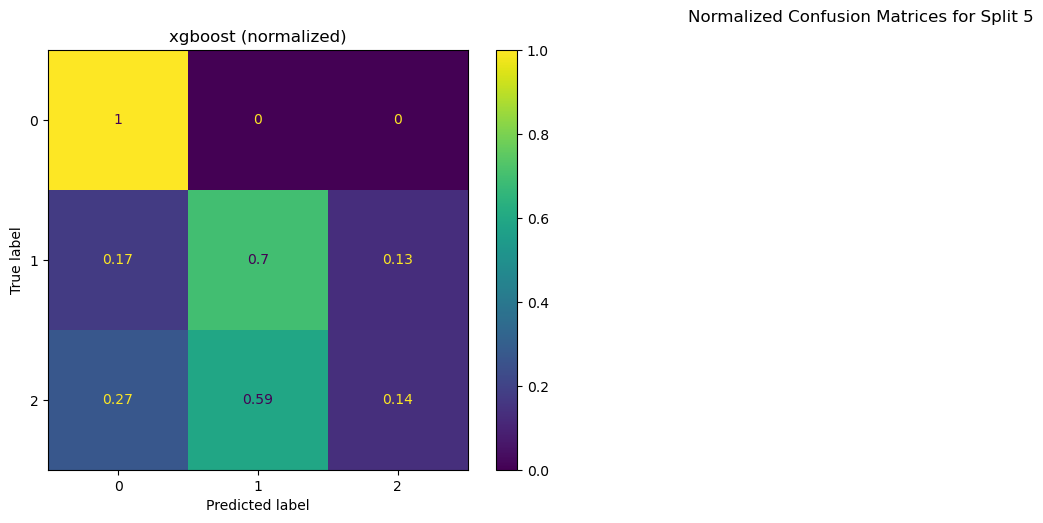

,Split,Model,Accuracy,Precision,Recall,F1
0,5,xgboost,0.518519,0.517645,0.518519,0.456553


=== Split 6 ===
Model 'mlp' was not trained on Split 6.
Model 'randomforest' was not trained on Split 6.


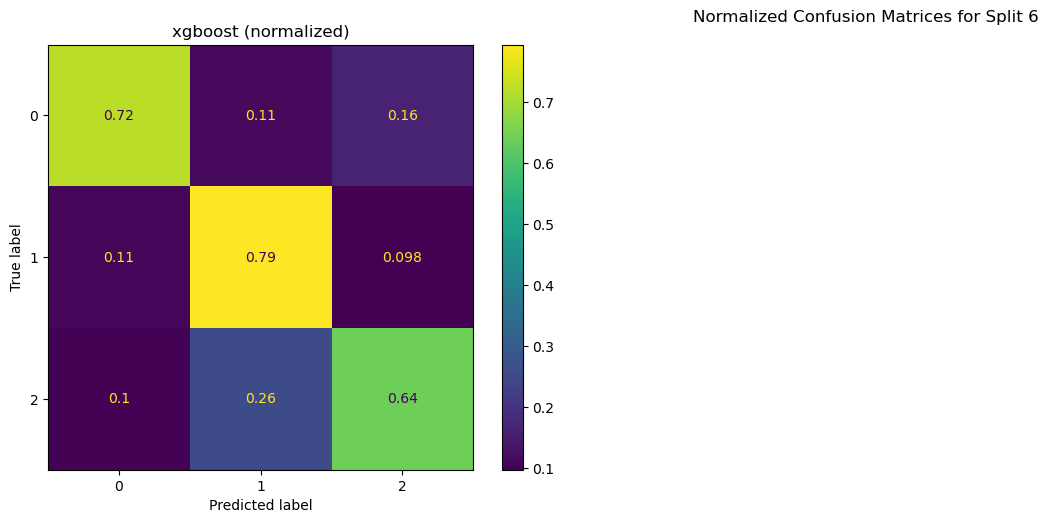

,Split,Model,Accuracy,Precision,Recall,F1
0,6,xgboost,0.722944,0.722823,0.722944,0.72148


,Split,Model,Accuracy,Precision,Recall,F1
0,0,xgboost,0.444444,0.719650,0.444444,0.469517
1,1,xgboost,0.345992,0.357985,0.345992,0.300795
2,2,xgboost,0.347222,0.628026,0.347222,0.331925
3,3,xgboost,0.383333,0.440586,0.383333,0.341786
4,4,xgboost,0.420824,0.576854,0.420824,0.404520
5,5,xgboost,0.518519,0.517645,0.518519,0.456553
6,6,xgboost,0.722944,0.722823,0.722944,0.721480


In [ ]:
# IMPORTANT: create a directory in data that is named after your model, save there the model and the model data per split
# name convention: model: data/{model_name}/model_split_{i}.joblib data: data/{model_name}/split_{i}_data.pkl

model_names = ["xgboost", "mlp", "randomforest"]
splits = range(7)
all_results = []

for split_number in splits:
    print(f"=== Split {split_number} ===")
    fig, axes = plt.subplots(1, len(model_names), figsize=(6 * len(model_names), 5))
    metrics_list = []

    for i, name in enumerate(model_names):
        model_path = f"../data/{name}/model_split_{split_number}.joblib"
        try:
            model = joblib.load(model_path)
            
            # Load Testdata and LabelEncoder for this Split and this model
            with open(f"../data/{name}/split_{split_number}_data.pkl", "rb") as f:
                _, _, X_test, y_test, le, _ = pickle.load(f)

        except FileNotFoundError:
            print(f"Model '{name}' was not trained on Split {split_number}.")
            axes[i].set_visible(False)
            continue

        y_pred = model.predict(X_test)

        ConfusionMatrixDisplay.from_estimator(
            model,
            X_test,
            y_test,
            display_labels=le.classes_,
            ax=axes[i],
            normalize="true"
        )
        axes[i].set_title(f"{name} (normalized)")

        metrics = {
            "Split": split_number,
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, average="weighted"),
            "Recall": recall_score(y_test, y_pred, average="weighted"),
            "F1": f1_score(y_test, y_pred, average="weighted"),
        }
        metrics_list.append(metrics)
    plt.suptitle(f"Normalized Confusion Matrices for Split {split_number}")
    plt.tight_layout()
    plt.show()

    if metrics_list:
        df_metrics = pd.DataFrame(metrics_list)
        display(df_metrics)
        all_results.extend(metrics_list)
    else:
        print("No models trained for this split.")

df_all = pd.DataFrame(all_results)
display(df_all)
